In [5]:
import numpy as np
import pulp
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import itertools
from scipy.spatial.transform import Rotation

@dataclass
class AtomType:
    symbol: str
    charge: float
    A: float
    rho: float
    C: float
    shannon_radius: float  # Shannon radius for symmetry constraints

@dataclass
class GridSite:
    position: np.ndarray
    fractional_coords: np.ndarray
    site_id: int

class CubicGrid:
    def __init__(self, lattice_param: float, grid_divisions: int):
        self.a = lattice_param
        self.divisions = grid_divisions
        self.spacing = lattice_param / grid_divisions
        self.sites = self._generate_sites()
        
    def _generate_sites(self) -> List[GridSite]:
        """Generate discrete grid sites with Cartesian and fractional coordinates"""
        sites = []
        idx = 0
        for i, j, k in itertools.product(range(self.divisions), repeat=3):
            # Cartesian coordinates
            pos = np.array([i, j, k]) * self.spacing
            # Fractional coordinates (0-1 range)
            frac = np.array([i, j, k]) / self.divisions
            sites.append(GridSite(pos, frac, idx))
            idx += 1
        return sites
    
    def periodic_distance(self, pos1: np.ndarray, pos2: np.ndarray) -> float:
        """Calculate minimum image distance with periodic boundary conditions"""
        delta = pos1 - pos2
        
        # Apply periodic boundary conditions
        for dim in range(3):
            if delta[dim] > self.a / 2:
                delta[dim] -= self.a
            elif delta[dim] < -self.a / 2:
                delta[dim] += self.a
                
        return np.linalg.norm(delta)

def buckingham_energy(r: float, A: float, rho: float, C: float) -> float:
    """Calculate Buckingham potential energy"""
    if r < 1e-6:  # Avoid division by zero
        return 0
    return A * np.exp(-r / rho) - C / r**6

KE_EV_ANG = 14.3996   # eV·Å / e²
eps_r = 10.0           # Relative permittivity

def ewald_energy(q1: float, q2: float, r: float) -> float:
    """Simplified Ewald electrostatic energy (real-space only)"""
    if r < 1e-6:  # Avoid division by zero
        return 0
    return KE_EV_ANG * q1 * q2 / (eps_r * r)

def compute_interaction_matrix(
        grid: CubicGrid,
        atom_types: Dict[str, AtomType],
        pair_params: Dict[Tuple[str, str], Tuple[float, float, float]],
        r_cutoff: float = 6.0
) -> Dict[Tuple[int, str, int, str], float]:
    """
    Construct (i,e1,j,e2) -> energy dictionary with periodic boundary conditions
    """
    interaction = {}
    n_sites = len(grid.sites)
    
    # Precompute all grid positions
    positions = [site.position for site in grid.sites]
    
    for i, j in itertools.combinations(range(n_sites), 2):
        # Use periodic distance calculation
        r = grid.periodic_distance(positions[i], positions[j])
        
        if r > r_cutoff:
            continue  # Skip pairs beyond cutoff radius

        for e1 in atom_types:
            for e2 in atom_types:
                # Get potential parameters
                if (e1, e2) in pair_params:
                    A, rho, C = pair_params[(e1, e2)]
                elif (e2, e1) in pair_params:
                    A, rho, C = pair_params[(e2, e1)]
                else:
                    # Use atom type defaults
                    at1, at2 = atom_types[e1], atom_types[e2]
                    A   = (at1.A   + at2.A)   / 2
                    rho = (at1.rho + at2.rho) / 2
                    C   = (at1.C   + at2.C)   / 2

                # Calculate Buckingham energy
                e_buck  = buckingham_energy(r, A, rho, C)
                
                # Calculate electrostatic energy
                q1, q2  = atom_types[e1].charge, atom_types[e2].charge
                e_ewald = ewald_energy(q1, q2, r)

                # Store interaction energy
                interaction[(i, e1, j, e2)] = e_buck + e_ewald
                
    return interaction

def get_symmetry_orbits(grid: CubicGrid, space_group: str = "Pm-3m") -> List[List[int]]:
    """
    Group symmetric equivalent sites based on space group symmetry
    Returns: List of orbits, each containing indices of symmetric sites
    """
    # Simplified implementation: Basic symmetry operations for cubic Pm-3m
    # Real applications should use full symmetry operations (e.g., via pymatgen)
    symmetry_ops = []
    
    # Identity operation
    symmetry_ops.append(np.eye(3))
    
    # 90-degree rotations (around x,y,z axes)
    for axis in range(3):
        for angle in [90, 180, 270]:
            rad = np.radians(angle)
            rot = np.eye(3)
            rot[(axis+1)%3, (axis+1)%3] = np.cos(rad)
            rot[(axis+1)%3, (axis+2)%3] = -np.sin(rad)
            rot[(axis+2)%3, (axis+1)%3] = np.sin(rad)
            rot[(axis+2)%3, (axis+2)%3] = np.cos(rad)
            symmetry_ops.append(rot)
    
    # Create orbit groups
    orbits = []
    visited = set()
    
    for i, site in enumerate(grid.sites):
        if i in visited:
            continue
            
        orbit = [i]
        visited.add(i)
        
        # Apply all symmetry operations
        for op in symmetry_ops:
            # Apply symmetry operation to fractional coordinates
            new_frac = np.dot(op, site.fractional_coords) % 1.0
            
            # Find nearest grid site
            closest_idx = None
            min_dist = float('inf')
            
            for j, other_site in enumerate(grid.sites):
                if j in visited:
                    continue
                    
                dist = np.linalg.norm(new_frac - other_site.fractional_coords)
                if dist < min_dist:
                    min_dist = dist
                    closest_idx = j
            
            # If close enough site found, add to current orbit
            if closest_idx is not None and min_dist < 1e-3:
                orbit.append(closest_idx)
                visited.add(closest_idx)
        
        orbits.append(orbit)
    
    return orbits

def add_symmetry_constraints(
        prob: pulp.LpProblem,
        x: Dict[Tuple[int, str], pulp.LpVariable],
        orbits: List[List[int]],
        atom_types: Dict[str, AtomType]
):
    """Add symmetry constraints to the integer programming problem"""
    for orbit in orbits:
        if len(orbit) < 2:
            continue  # Single-site orbits need no constraints
            
        # All sites in orbit must have identical atom occupation
        for e in atom_types:
            # Create reference variable
            ref_var = x[(orbit[0], e)]
            
            # Constrain other sites to match reference
            for site_idx in orbit[1:]:
                prob += x[(site_idx, e)] == ref_var

def add_proximity_constraints(
        prob: pulp.LpProblem,
        grid: CubicGrid,
        x: Dict[Tuple[int, str], pulp.LpVariable],
        atom_types: Dict[str, AtomType],
        min_distance_factor: float = 0.7
):
    """Add proximity constraints to prevent atom overlap"""
    positions = [site.position for site in grid.sites]
    n_sites = len(positions)
    
    for i, j in itertools.combinations(range(n_sites), 2):
        r = grid.periodic_distance(positions[i], positions[j])
        
        for e1 in atom_types:
            r1 = atom_types[e1].shannon_radius
            for e2 in atom_types:
                r2 = atom_types[e2].shannon_radius
                min_dist = min_distance_factor * (r1 + r2)
                
                if r < min_dist:
                    # Prevent simultaneous occupation of too-close positions
                    prob += x[(i, e1)] + x[(j, e2)] <= 1

def solve_global_ip(
        grid: CubicGrid, 
        atom_types: Dict[str, AtomType], 
        composition: Dict[str, int],
        space_group: Optional[str] = None
) -> List[Tuple[str, np.ndarray]]:
    """Solve global integer programming problem with periodic boundaries and symmetry constraints"""
    prob = pulp.LpProblem("Global_CSP", pulp.LpMinimize)
    n_sites = len(grid.sites)
    
    # Create decision variables: x[i,e] = 1 means place atom type e at site i
    x = {(i, e): pulp.LpVariable(f"x_{i}_{e}", cat='Binary')
         for i in range(n_sites) for e in atom_types}

    # Constraint 1: At most one atom per site
    for i in range(n_sites):
        prob += pulp.lpSum(x[(i, e)] for e in atom_types) <= 1

    # Constraint 2: Satisfy element composition
    for e, count in composition.items():
        prob += pulp.lpSum(x[(i, e)] for i in range(n_sites)) == count

    print('Computing interaction matrix...')
    interaction = compute_interaction_matrix(grid, atom_types, pair_params, r_cutoff=5.0)

    # Add proximity constraints to prevent atom overlap
    print('Adding proximity constraints...')
    add_proximity_constraints(prob, grid, x, atom_types, min_distance_factor=0.75)
    
    # Add symmetry constraints
    if space_group:
        print(f'Adding {space_group} symmetry constraints...')
        orbits = get_symmetry_orbits(grid, space_group)
        add_symmetry_constraints(prob, x, orbits, atom_types)
    
    # Create auxiliary variables z[i,e1,j,e2] = x[i,e1] * x[j,e2]
    print('Linearizing quadratic objective function...')
    z = {}
    for (i, e1, j, e2), energy in interaction.items():
        if i >= j: 
            continue  # Avoid double counting
            
        z_var = pulp.LpVariable(f"z_{i}_{e1}_{j}_{e2}", cat='Binary')
        z[(i, e1, j, e2)] = z_var
        
        # Ensure z[i,e1,j,e2] = x[i,e1] * x[j,e2]
        prob += z_var <= x[(i, e1)]
        prob += z_var <= x[(j, e2)]
        prob += z_var >= x[(i, e1)] + x[(j, e2)] - 1

    # Set objective function: minimize total energy
    print('Setting objective function...')
    prob += pulp.lpSum(
        energy * z[key] for key, energy in interaction.items() if key in z
    )

    # Solver configuration
    print(f"Problem size: {n_sites} sites, {len(atom_types)} atom types, {len(z)} interactions")
    solver = pulp.GUROBI(
        msg=1,
        TimeLimit=300,   # 5 minutes
        MIPFocus=1,      # Focus on finding feasible solutions
        Presolve=2,      # Aggressive preprocessing
        Heuristics=0.5   # Heuristic search intensity
    )
    
    # Solve the problem
    print('Solving integer program...')
    prob.solve(solver)
    print('Status:', pulp.LpStatus[prob.status])
    
    # Extract results
    selected = []
    for (i, e), var in x.items():
        if pulp.value(var) > 0.5:
            selected.append((e, grid.sites[i].position))
    
    return selected

# === Parameter Setup ===
lattice_param = 4.0  # Lattice parameter (Å)
grid_divisions = 8    # Grid divisions per side
space_group = "Pm-3m" # Space group symmetry

composition = {'Sr': 1, 'Ti': 1, 'O': 3}  # Chemical composition

# Atom type definitions (with Shannon radii)
atom_types: Dict[str, AtomType] = {
    'Sr': AtomType(symbol='Sr', charge=2.0, A=1450.0, rho=0.35, C=0.0, shannon_radius=1.18),
    'Ti': AtomType(symbol='Ti', charge=4.0, A=1000.0, rho=0.35, C=0.0, shannon_radius=0.42),
    'O':  AtomType(symbol='O',  charge=-2.0, A=22764.0, rho=0.149, C=27.88, shannon_radius=1.35)
}

# Atom pair potential parameters
pair_params = {
    ('Sr','O'): (1455.2, 0.3585, 0.0),
    ('Ti','O'): (3147.6, 0.2870, 0.0),
    ('O','O') : (22764.0, 0.1490, 27.88),
    ('Sr','Sr'): (2386.0, 0.3327, 0.0),
    ('Ti','Ti'): (2000.0, 0.3500, 0.0),
    ('Sr','Ti'): (1155.0, 0.3560, 0.0)
}

# === Main Execution ===
if __name__ == "__main__":
    print("Creating crystal grid...")
    grid = CubicGrid(lattice_param, grid_divisions)
    
    print("Solving for globally optimal structure...")
    selected_atoms = solve_global_ip(
        grid, 
        atom_types, 
        composition,
        space_group=space_group
    )
    
    print("\nPredicted atomic positions:")
    for atom in selected_atoms:
        element, pos = atom
        print(f"{element}: {pos}")

Creating crystal grid...
Solving for globally optimal structure...
Computing interaction matrix...
Adding proximity constraints...
Adding Pm-3m symmetry constraints...
Linearizing quadratic objective function...
Setting objective function...
Problem size: 512 sites, 3 atom types, 1177344 interactions
Solving integer program...
Set parameter TimeLimit to value 300
Set parameter MIPFocus to value 1
Set parameter Presolve to value 2
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i9-11900H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  300
Heuristics  0.5
MIPFocus  1
Presolve  2

Optimize a model with 3843197 rows, 1178880 columns and 8865780 nonzeros
Model fingerprint: 0x0ca8bb2c
Variable types: 0 continuous, 1178880 integer (0 binary)
Coefficient statistics:
  Ma

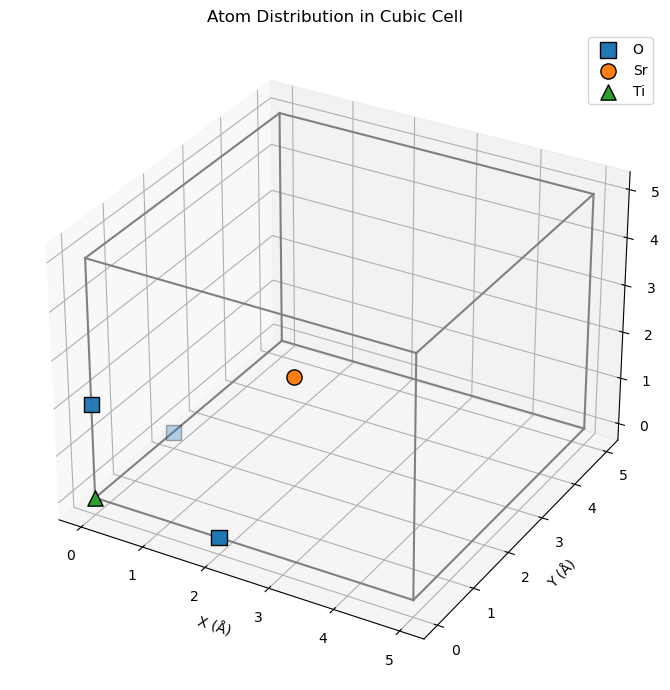

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Expecting that `selected_atoms` has been produced by the solver ===
# selected_atoms is a list of tuples: (element_symbol, np.ndarray([x, y, z]))
# For demonstration, I'll create a dummy list if it doesn't exist.

# Split positions and element labels
chosen_elements = [elem for elem, pos in selected_atoms]
chosen_positions = [pos for elem, pos in selected_atoms]

# === Visualization Parameters ===
lattice_parameter = 5.0   # Update if your solver used a different value
grid_divisions = 4
spacing = lattice_parameter / grid_divisions

# 1. Draw 3D scatter
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

unique_types = sorted(set(chosen_elements))
markers = {'Sr': 'o', 'Ti': '^', 'O': 's'}
for elem in unique_types:
    idxs = [i for i, t in enumerate(chosen_elements) if t == elem]
    pts = np.array([chosen_positions[i] for i in idxs])
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
               label=elem,
               s=120,
               marker=markers.get(elem, 'o'),
               edgecolors='black')

# Draw cube edges
corners_frac = np.array([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]])
corners = corners_frac * lattice_parameter
for a in range(8):
    for b in range(a + 1, 8):
        if np.sum(np.abs(corners_frac[a] - corners_frac[b])) == 1:
            p1, p2 = corners[a], corners[b]
            ax.plot(*zip(p1, p2), color='gray')

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('Atom Distribution in Cubic Cell')
ax.legend()
plt.tight_layout()
plt.show()
